# **Lab 2: Exploring Image Data**
**Name(s):** Luke Voinov, Tiffany Nguyen

Much of the code was adapted from Eric Larson's github,  particularly the notebook '04. Dimension Reduction and Images.ipynb'

https://github.com/eclarson/MachineLearningNotebooks/tree/master

We will denote the notebook '04. Dimension Reduction and Images.ipynb' with (1).


As you will see, the dataset is about chess positions on various board styles:

"Chess Positions". https://www.kaggle.com/datasets/koryakinp/chess-positions

The dataset contains too many images to deal with locally so we reduced the size to only 2k images.


## **1. Business Understanding**
*[2 points] Give an overview of the dataset. Describe the purpose of the data set you selected (i.e., why was this data collected in the first place?). What is the prediction task for your dataset and which third parties would be interested in the results? Why is this data important? Once you begin modeling, how well would your prediction algorithm need to perform to be considered useful to the identified third parties? Be specific and use your own words to describe the aspects of the data.*


The person who created this dataset says that "[t]he goal of the project is to build a model able to generate FEN description based on a schematic image of a chess board." Another use for this data that's not associated with the original use is predicting what the next best move should be.

The prediction task for our dataset is classification. We can use the images as input to classify a each piece and square, thus being able to generate notation for the board. Alternatively, the dataset could be used to analyze the board and correlate the current position with a probability of winning.

The companies that could benefit the most from our results are chess.com and lichess. It would allow them to implement a feature (that they don't currently have) that would allow players to take a picture of their board and automatically recieve the FEN notation, cutting out the need to players to manually annotate a game. This would be particularly valuable to players as it cuts out the manual process of notationg a board. Players would be able to take a photo and plug the generated notation into some chess engine (on chess.com, say) to see which moves a bot analyzes as best. 

To be useful, the algorithm would have to generate FEN notation for each postion perfectly. It would be game changing if the generated FEN misplaced one of the piece. It would also be somewhat tedious for a player to manually double check if the generated postion is the same as the one they had a picture of. I assume that if we trained our algorithm on the actual 100k dataset size this wouldn't the FEN would be generated pretty well for the most part.

## **2. Data Preparation** 


In [ ]:
# This section of code is borrowed from (1) to get the libraries

import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

print('Seaborn:', sns. __version__)
print('Pandas:', pd.__version__)
print('Numpy:',np.__version__)
# Python: 3.12.3

Seaborn: 0.13.2
Pandas: 2.3.2
Numpy: 1.26.4


### **2.1.1 As Numpy Arrays**
*[.5 points] Read in your images as numpy arrays. Resize and recolor images as necessary.*

In [2]:
# this code is adapted from Gerry P, https://stackoverflow.com/questions/72076962/how-to-load-all-the-image-paths-from-a-directory-into-a-pandas-dataframe-column
# This code will list through every image in my folder and put it into a numpy array

import os
import numpy as np
from PIL import Image

# 'all' because there is no need to split between training and testing
source_dir = r"C:\Users\lukev\Downloads\Chess\all"

# This code looks inside my 'all' folder and finds all my images
filelist = os.listdir(source_dir)
print(f"Loading {len(filelist)} images as numpy arrays...")

# Load all images into a list of numpy arrays
images = []
for f in filelist:
    fpath = os.path.join(source_dir, f) # this allow me to access each image path to store each image as an array
    img_array = np.array(Image.open(fpath))
    images.append(img_array)

# Convert list to numpy array
images = np.array(images)
print(f"Loaded {len(images)} images")
print(f"Image array shape: {images.shape}")

Loading 2000 images as numpy arrays...
Loaded 2000 images
Image array shape: (2000, 400, 400, 3)



### **2.1.2 Linearization**
*[.4 points] Linearize the images to create a table of 1-D image features (each row should be one image).*

In [3]:
# Code adapted from github Coilot to reduce the pixel size from 400x400 to 224x224
# 400x400 features would have required too much time to process
# We originally reduced it to 64x64 but the quality was too blurry
# This code first reduces the pixel resolution of each image and then flattens each image

import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import time

start_time = time.time()

# Get image dimensions from first image
print(f"Original image size: {images[0].shape}")

# convert to 224x224 pixels
target_size = (224, 224)
print(f"Downsampling to: {target_size}")

# number of features when flattened
n_features = target_size[0] * target_size[1]

# create a zero matrix that will store each image (rows) and has enough columns to store the number of features when each image is flattened
X = np.zeros((len(images), n_features), dtype=np.float32)

for i in range(len(images)):
    img = images[i]
    
    # Convert to grayscale if color image
    if len(img.shape) == 3:
        img = np.mean(img, axis=2)
    
    # resize to 224x224
    img_pil = Image.fromarray(img.astype(np.uint8))
    img_resized = img_pil.resize(target_size, Image.Resampling.LANCZOS)
    img_array = np.array(img_resized, dtype=np.float32) / 255.0
    
    # each row stores the flattened array (vector of 224x224)
    X[i] = img_array.flatten()

h, w = target_size  # Set dimensions for later use
end_time = time.time()
print(f"\nProcessing completed in {end_time - start_time:.2f} seconds")
print(f"Dataset shape: {X.shape}")

Original image size: (400, 400, 3)
Downsampling to: (224, 224)

Processing completed in 8.24 seconds
Dataset shape: (2000, 50176)


### **2.1.3 Visualization**
*[.1 points] Visualize several images.*

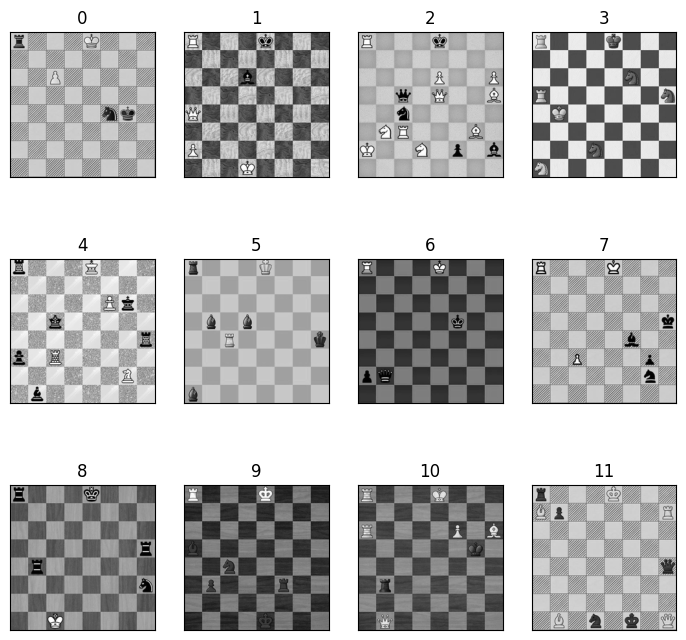

In [12]:
# Code adapted from (1) to plot 12 images from our dataset

def plot_gallery(images, h, w, n_row=3, n_col=4):
    """Helper function to plot a gallery of portraits"""
    plt.figure(figsize=(1.7 * n_col, 2.3 * n_row))
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        plt.imshow(images[i].reshape((h, w)), cmap=plt.cm.gray)
        plt.title(i, size=12)
        plt.xticks(())
        plt.yticks(())

plot_gallery(X, h, w) # Note that X uses the 224x224 image resolution


## **3. Data Reduction**


### **3.1.1 Linear Dimensionality Reduction with PCA**
*[.5 points] Perform linear dimensionality reduction of the images using principal components analysis. Visualize the explained variance of each component.*

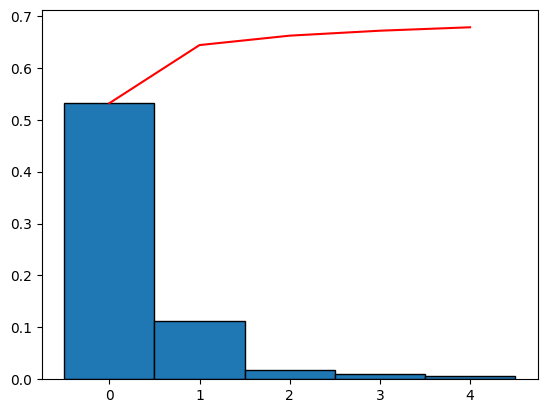

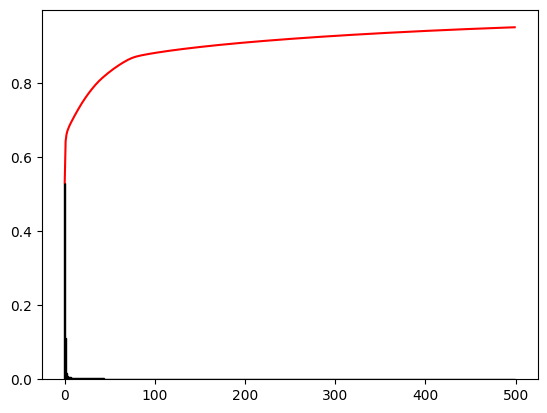


Values at Component 10:
Cumulative explained variance: 0.703561
Percentage of total variance explained by first 100 components: 70.36%

Values at Component 85:
Cumulative explained variance: 0.875179
Percentage of total variance explained by first 85 components: 87.52%

Values at Component 500:
Cumulative explained variance: 0.951613
Percentage of total variance explained by first 500 components: 95.16%


In [10]:
# Example adapted from (1). This code plots how much information each eigenvector provides 
# manipulated from Sebastian Raschka Example (your book!)
# also from hi blog here: http://sebastianraschka.com/Articles/2015_pca_in_3_steps.html

from sklearn.decomposition import PCA

# this is a scree plot
def plot_explained_variance(pca, n_components):
    
    explained_var = pca.explained_variance_ratio_
    cum_var_exp = np.cumsum(explained_var)

    x_axis = np.arange(0,n_components)

    plt.bar(x_axis,explained_var, 1, edgecolor='k')
    plt.plot(x_axis, cum_var_exp, 'r-')
    plt.show()
    
    
    if len(pca.explained_variance_ratio_) >= 10:
        cumulative_var_10 = np.cumsum(pca.explained_variance_ratio_)[9]
        
        print(f"\nValues at Component 10:")
        print(f"Cumulative explained variance: {cumulative_var_10:.6f}")
        print(f"Percentage of total variance explained by first 100 components: {cumulative_var_10*100:.2f}%")

    if len(pca.explained_variance_ratio_) >= 85:
        cumulative_var_85 = np.cumsum(pca.explained_variance_ratio_)[84]
        
        print(f"\nValues at Component 85:")
        print(f"Cumulative explained variance: {cumulative_var_85:.6f}")
        print(f"Percentage of total variance explained by first 85 components: {cumulative_var_85*100:.2f}%")

    if len(pca.explained_variance_ratio_) >= 500:
        cumulative_var_500 = np.cumsum(pca.explained_variance_ratio_)[499]
        
        print(f"\nValues at Component 500:")
        print(f"Cumulative explained variance: {cumulative_var_500:.6f}")
        print(f"Percentage of total variance explained by first 500 components: {cumulative_var_500*100:.2f}%")
        
n_components=5
pca = PCA(n_components)
X_pca = pca.fit(X)
plot_explained_variance(pca, n_components)
plt.show()

# added the below code to show how much variance up to 500 features can explain
n_components=500
pca = PCA(n_components)
X_pca = pca.fit(X)
plot_explained_variance(pca, n_components)

*Analyze how many dimensions are required to adequately represent your image data. Explain your analysis and conclusion.*

The graph was interactive for us so we were able to quickly see how many eigenvectors are required. We print out the explained variance for each accumulation of eigenvectors to show the most important locations. The first knee of the curve happens after 1 eigenvector and provides 64% of the explained variance. 10 eigenvectors is still a small number of eigenvectors and provides a decent improvement in explained variance (70% vs 64%). The next knee in the curve happens at around 85 eigenvectors and is still a decently small number. The explained variance is much better at 85 eigenvectors (87% vs 70%). Our final check was to see how a large number of eigenvectors would influence the explained variance. At this point it's not worthwhile to include more eigenvectors because each eigenvector is decreasingly meaningful (it's incredibly slow to increase explained variance by 8% with 400 eigenvectors (87% to 95%)).

We conclude that a meaningful number of dimensions is between 85 and 500 dimensions.

*Below we visualize the most important eignevectors to better learn the dataset*

Extracting the top 85 eigenpositions from 2000 positions
CPU times: total: 30.4 s
Wall time: 3 s


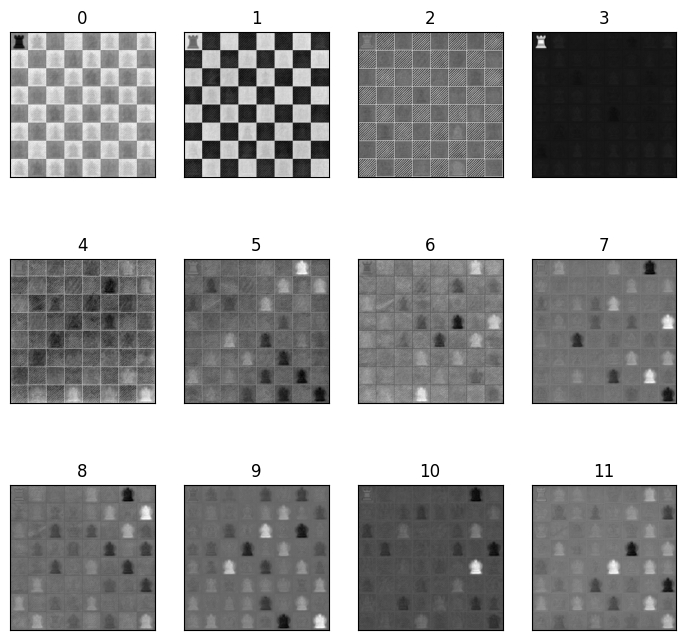

In [15]:
# This code is borrowed from (1)
from sklearn.decomposition import PCA

n_components = 85 # smaller for speed because we show only the top 12 anyways
print ("Extracting the top %d eigenpositions from %d positions" % (
    n_components, X.shape[0]))

pca = PCA(n_components=n_components)
%time pca.fit(X.copy())
eigenpositions = pca.components_.reshape((n_components, h, w))

plot_gallery(eigenpositions, h, w)

### **3.1.2 Linear Dimensionality Reduction with Randomized Principle Components Analysis**
*[.5 points] Perform linear dimensionality reduction of your image data using randomized principle components analysis. Visualize the explained variance of each component.*

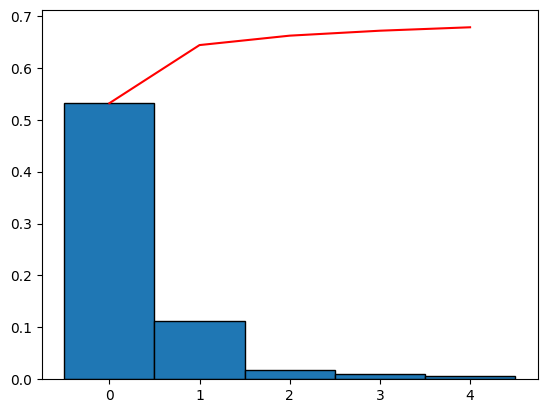

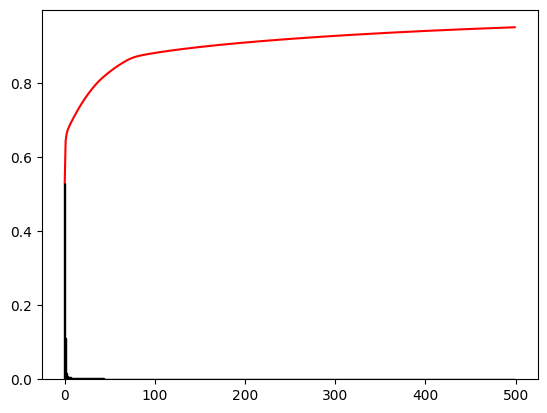


Values at Component 10:
Cumulative explained variance: 0.703561
Percentage of total variance explained by first 100 components: 70.36%

Values at Component 85:
Cumulative explained variance: 0.875179
Percentage of total variance explained by first 85 components: 87.52%

Values at Component 500:
Cumulative explained variance: 0.951600
Percentage of total variance explained by first 500 components: 95.16%


In [5]:
# Example adapted from (1). This code plots how much information each eigenvector provides 
# uses randomized pca
# manipulated from Sebastian Raschka Example (your book!)
# also from hi blog here: http://sebastianraschka.com/Articles/2015_pca_in_3_steps.html

from sklearn.decomposition import PCA

n_components=5
rpca = PCA(n_components, svd_solver='randomized')
X_pca = rpca.fit(X)
plot_explained_variance(rpca,n_components)
plt.show()

n_components=500
# added the below code to show how much variance up to 500 features can explain
rpca = PCA(n_components, svd_solver='randomized')
X_pca = rpca.fit(X)
plot_explained_variance(rpca,n_components)

*Analyze how many dimensions are required to adequately represent your image data. Explain your analysis and conclusion*

Our analysis for randomized PCA is the same as for non-randomized PCA because they yield bascially the same eigenvectors. Randomized PCA is just quicker due to a different implementation.

Extracting the top 85 eigenpositions from 2000 positions
CPU times: total: 31.2 s
Wall time: 3.27 s


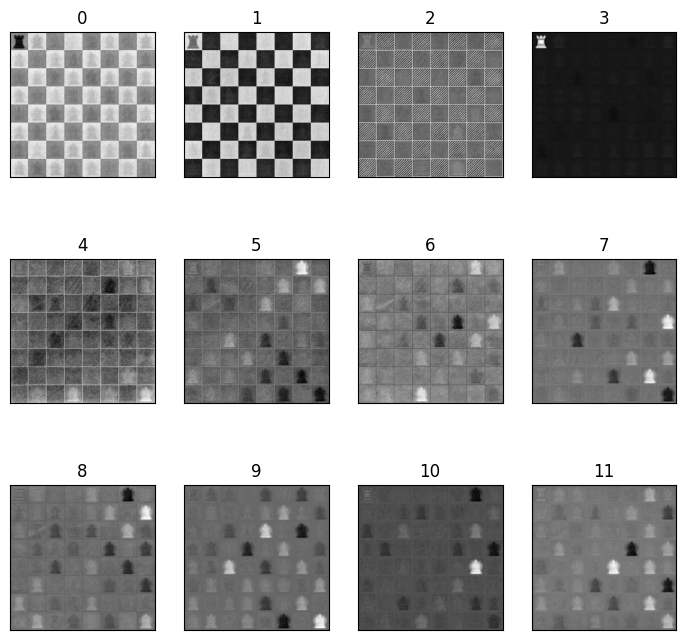

In [14]:
# code adapted from (1)

n_components = 85
print ("Extracting the top %d eigenpositions from %d positions" % (
    n_components, X.shape[0]))

rpca = PCA(n_components=n_components, svd_solver='randomized')
%time rpca.fit(X.copy())
eigenpositions = rpca.components_.reshape((n_components, h, w))

plot_gallery(eigenpositions, h, w)

### **3.1.3 Comparison between dimensionality methods (PCA & Randomized PCA)**
[2 points]  Compare the representation using PCA and Randomized PCA. The method you choose to compare dimensionality methods should quantitatively explain which method is better at representing the images with fewer components.  Do you prefer one method over another? Why?

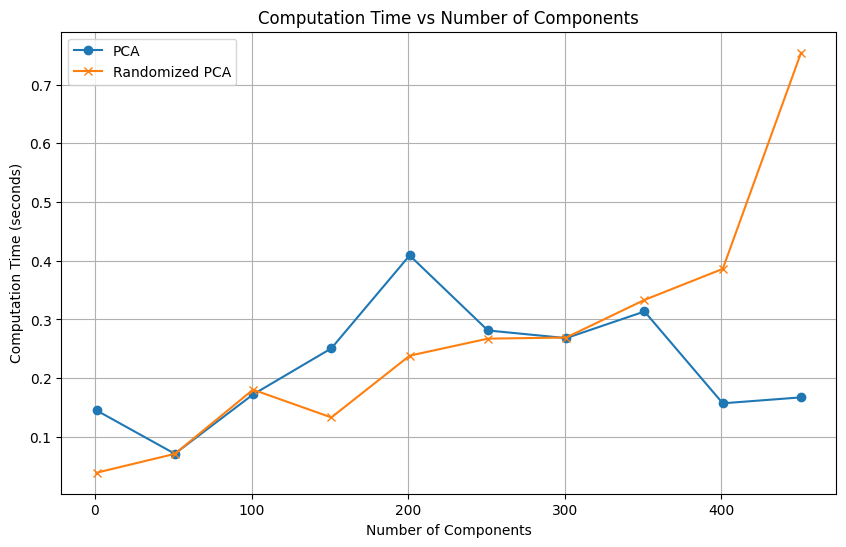

In [47]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.datasets import make_blobs
import time

# Generate synthetic data
n_samples = 2000
n_features = 500
n_clusters = 10
X, _ = make_blobs(n_samples=n_samples, n_features=n_features, centers=n_clusters, random_state=42)

# Number of components to test
n_components_range = range(1, 501, 50)

# Lists to store computation times
pca_times = []
randomized_pca_times = []

# Measure computation time for PCA and Randomized PCA
for n_components in n_components_range:
    # PCA
    pca = PCA(n_components=n_components)
    start_time = time.time()
    pca.fit(X)
    pca_times.append(time.time() - start_time)
    
    # Randomized PCA
    randomized_pca = PCA(n_components=n_components, svd_solver='randomized', random_state=42)
    start_time = time.time()
    randomized_pca.fit(X)
    randomized_pca_times.append(time.time() - start_time)

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(n_components_range, pca_times, label='PCA', marker='o')
plt.plot(n_components_range, randomized_pca_times, label='Randomized PCA', marker='x')
plt.xlabel('Number of Components')
plt.ylabel('Computation Time (seconds)')
plt.title('Computation Time vs Number of Components')
plt.legend()
plt.grid()
plt.show()

We do not have a prefer method for our use case, but there are certain times where we would prefer one over the other. We prefer to use Randomized PCA when working with fewer components (if under 150), due to its faster computation time in this range. However, for higher numbers of components (>=250), PCA is more efficient, making it the better choice when a more complete representation is needed.

Due to our dataset being small (2000 images), there are no average results. We observe less stable or consistent runtime trends between PCA and Randomized PCA. In small datasets, the performance difference between exact and approximate algorithms are minimal. Instead, we observe no clear average trend in computation time as components increase.

### **3.2.1 Feature Extraction**

Let's apply feature extraction using an implementation of DAISY. We chose DAISY due to its ability to efficiently capture dense, localized image descriptors. It is well-suited for tasks requiring scale and rotation invariance, making it ideal for applications involving image matching or object recognition. In our case, we are using object recognition to recognize what chess pieces are on the board (the images we are using). It further enhances its suitability for extracting meaningful features from visual data.

Daisy works by computing a dense grid of descriptors across the image. where each descriptor is based on histograms of gradient orientations within a circular region. These regions are divided into concentric rings, and the histograms are weighted by Gaussian kernels to emphasize the center. The structure ensures that the descriptors are robust to variations in scale, rotation, and lighting, while maintaining computational efficiency.

Let's prepare our images for DAISY implementation. 

In [8]:
# Code borrowed by Eric Larson, 04. Dimension Reduction and Images

# WORKING ON THIS PART

from skimage.transform import resize

idx_to_reconstruct = int(np.random.rand(1)*len(X)) # Randomly selecting an image from our data set
img  = X[idx_to_reconstruct].reshape((h,w)) # Reshaping the selected image to its original dimensions

C:\Users\lukev\AppData\Local\Temp\ipykernel_46920\1061221933.py:7: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  idx_to_reconstruct = int(np.random.rand(1)*len(X)) # Randomly selecting an image from our data set


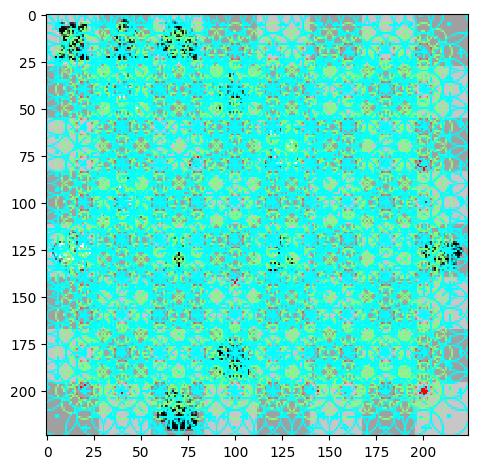

In [108]:
# Code borrowed by Eric Larson, 04. Dimension Reduction and Images

from skimage.feature import daisy
from matplotlib.pyplot import imshow

# lets first visualize what the daisy descriptor looks like
features, img_desc = daisy(img, 
                           step=20, 
                           radius=20, 
                           rings=2, 
                           histograms=8, 
                           orientations=8, 
                           visualize=True)
imshow(img_desc)
plt.grid(False)
plt.show()

We can see that the chessboard has a highly repetitive high-contrast grid, hence why DAISY extracts the dense gradient orientation histograms across circular regions. The pieces create some irregularities in the pattern, but they're drowned out visually due to the grid.

In [109]:
from skimage.feature import daisy
from skimage.transform import resize
import numpy as np

# Resize all images to a consistent shape (e.g., 64x64)
target_shape = (64, 64)
images_resized = np.array([resize(img, target_shape) for img in images])

# Compute DAISY features for all resized images
daisy_feature_imgs = np.array(
    [daisy(row, step=20, radius=20, rings=2, histograms=8, orientations=8, visualize=False).flatten() for row in images_resized]
)

# Debugging: Print original and post-DAISY feature shapes
print("----- Daisy Feature Extraction Summary -----")
print(f"Original shape: {images_resized.shape}")
print(f"Original number of features: {images_resized.shape[1] * images_resized.shape[2]}")

print(f"Post Daisy shape: {daisy_feature_imgs.shape}")
print(f"Post-Daisy number of features: {daisy_feature_imgs.shape[1]}")

----- Daisy Feature Extraction Summary -----
Original shape: (1288, 64, 64)
Original number of features: 4096
Post Daisy shape: (1288, 544)
Post-Daisy number of features: 544


The summary shows how the DAISY descriptor reduces or transforms the raw pixel data into a more compact and meaningful feature representation. We can see that it reduced from 4096 raw pixel values to 544 meaningful features per image.

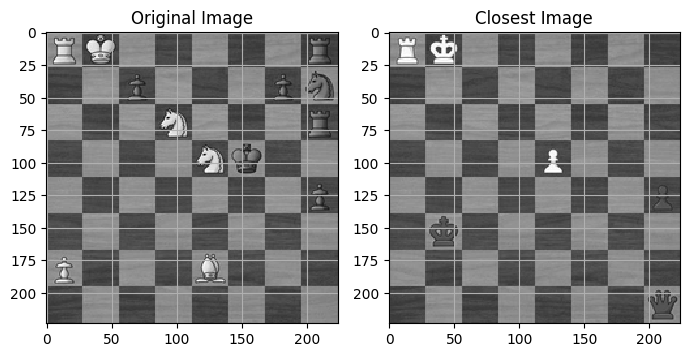

In [110]:
# Code borrowed by Eric Larson, 04. Dimension Reduction and Images

import copy

dist_matrix = pairwise_distances(X, metric='euclidean') # Adapted from Copilot to figure out metric

# find closest image to current image
idx1 = 5
distances = copy.deepcopy(dist_matrix[idx1,:])
distances[idx1] = np.infty # dont pick the same image!
idx2 = np.argmin(distances)

plt.figure(figsize=(7,10))
plt.subplot(1,2,1)
imshow(X[idx1].reshape((h,w)))
plt.title("Original Image")
plt.grid()

plt.subplot(1,2,2)
imshow(X[idx2].reshape((h,w)))
plt.title("Closest Image")
plt.grid()

Above you can see that the closet image to the original image has the same positions for both for the Rook and the King. The Rook being in the top left is the most important feature, hence the "closest image" matches with this.

### **3.2.2 Feature Extraction for Prediction Task**


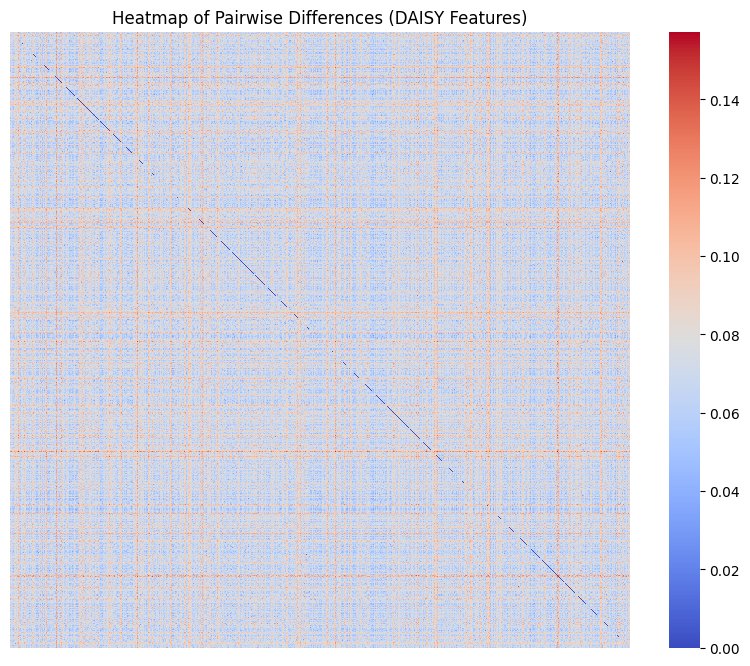

In [111]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import pairwise_distances

# Compute pairwise distances
daisy_features = daisy_feature_imgs
dist_matrix = pairwise_distances(daisy_features)

# Plot heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(dist_matrix, cmap='coolwarm', xticklabels=False, yticklabels=False)
plt.title('Heatmap of Pairwise Differences (DAISY Features)')
plt.show()

**The feature extraction method does show promise for our prediction task.** We know this because of the heatmap above, where it displays non-uniform patterns, specifically a mix of dark blue blocks and intersecting orange/red lines. This indicates that some DAISY features are highly similar, while others are noticeably different (the high pairwise difference being orange/red). This matters because a good feature extraction method should be able to compress similar inputs together and separate different inputs. With our feature extraction method DAISY, it is doing exactly that here.

The strong vertical and horizontal grid lines mean that many descriptors are nearly identifical, producing large rectangular blocks. We can expect this due to the repetitive pattern of a chessboard. All the empty square with the same gradient pattern yield very similar DAISY descriptors, so the pairwise differences are small (indicated as blue in the heatmap). When one row/column is very different, you can see there's a stripe of higher differences intersecting others.

Squares with pieces will from "hot" differences relative to the empty square. If a square contains a piece, its descriptor will be intermediate, making it less clustered. With our DAISY descriptors that we implemented, it captured the board's repetitive structure but also detect the pieces on the board.

## **4. Exceptional Work**
[1 point] One idea (required for 7000 level students): Perform feature extraction upon the images using DAISY. Rather than using matching on the images with the total DAISY vector, you will instead use key point matching. You will need to investigate appropriate methods for key point matching using DAISY. NOTE: this often requires some type of brute force matching per pair of images, which can be computationally expensive. Does it perform better than not using key point matching? 

Using 100 images for DAISY analysis (out of 2000 total)
Applying DAISY feature extraction to sample images...
Extracted DAISY features for 100 images
Finding keypoint matches between image pairs...

Top 10 image pairs with most keypoint matches:
1. Images 0 and 7: 1589 matches
2. Images 6 and 60: 1536 matches
3. Images 0 and 58: 1505 matches
4. Images 7 and 58: 1501 matches
5. Images 9 and 10: 1487 matches
6. Images 0 and 11: 1469 matches
7. Images 51 and 64: 1455 matches
8. Images 3 and 90: 1450 matches
9. Images 8 and 81: 1440 matches
10. Images 51 and 90: 1437 matches


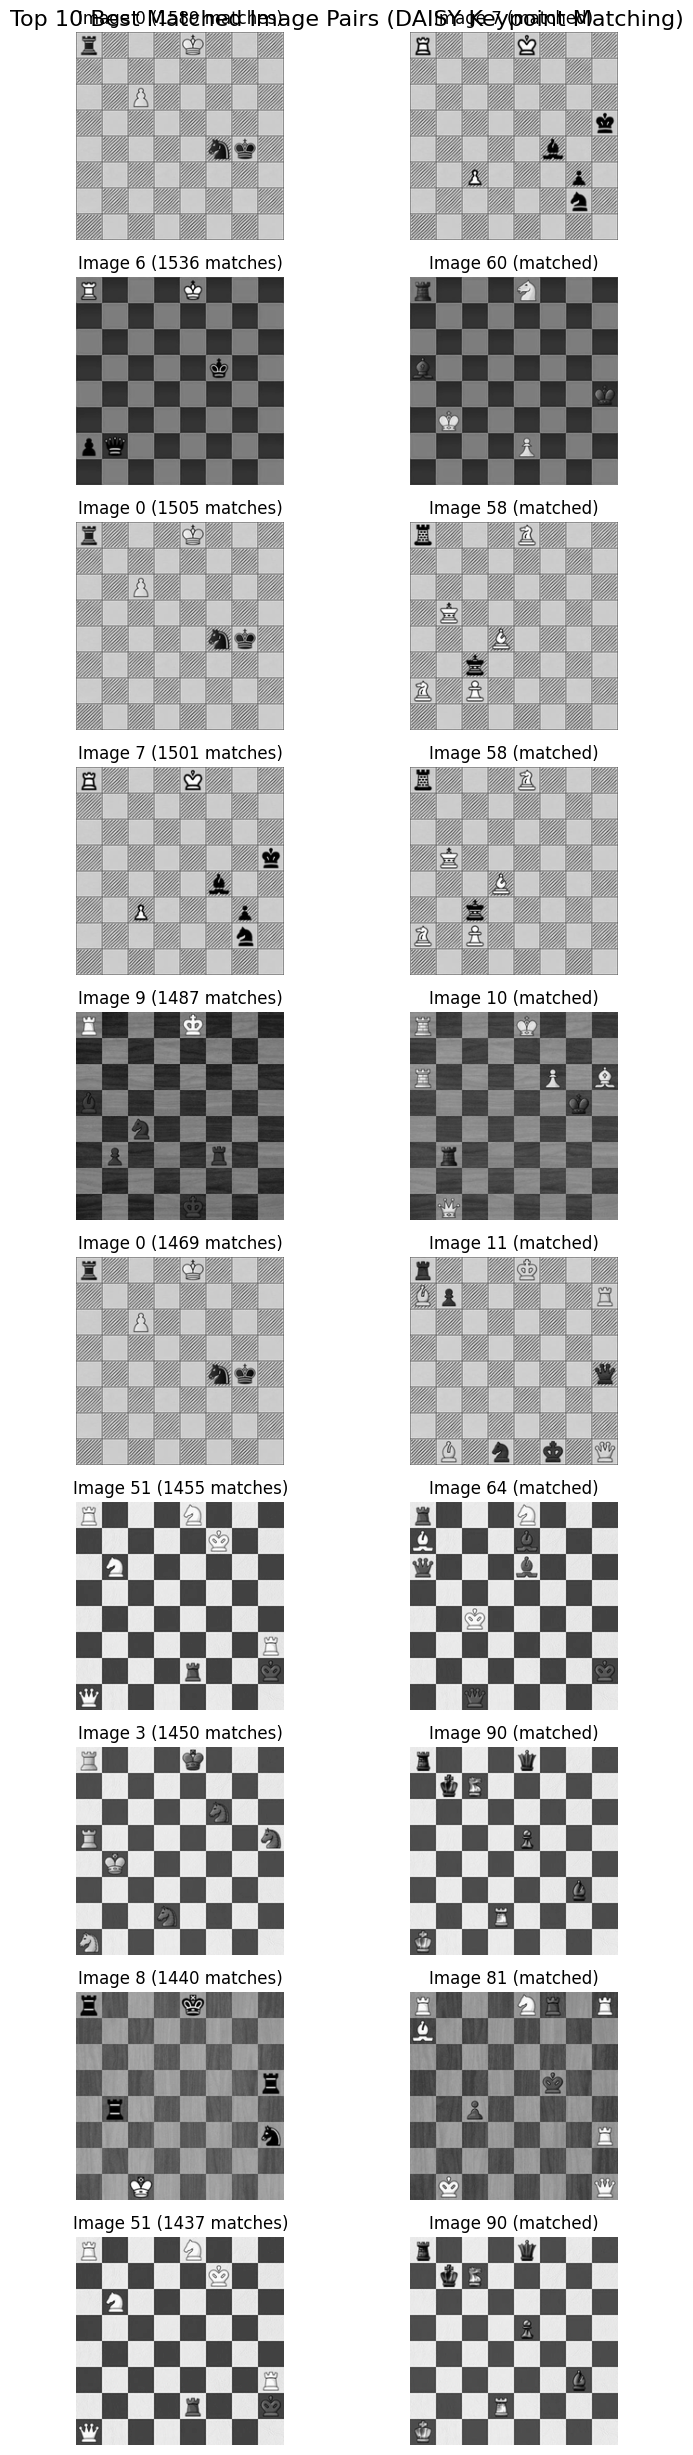

In [7]:
# code adapted from (1)
# you will need to repeat this for all pairs of images
from skimage.feature import match_descriptors
from skimage.feature import daisy


def apply_daisy(row,shape): # no reshape in this function
    feat = daisy(row.reshape(shape), step=5, radius=5, 
                 rings=2, histograms=8, orientations=4, 
                 visualize=False)
    s = feat.shape # PxQxR
    #P = ceil((Height - radius*2) / step) 
    #Q = ceil((Width - radius*2) / step) 
    #R = (rings * histograms + 1) * orientations
    return feat.reshape((s[0]*s[1],s[2]))

m_ratio = 0.9

# Use only 100 samples for faster computation
n_sample_images = min(100, len(X))
X_sample = X[:n_sample_images]
print(f"Using {n_sample_images} images for DAISY analysis (out of {len(X)} total)")

# Apply DAISY to sample images
print("Applying DAISY feature extraction to sample images...")
d = []
for i in range(n_sample_images):
    d.append(apply_daisy(X_sample[i], (h, w)))

print(f"Extracted DAISY features for {len(d)} images")

# Find matches between all pairs and store match counts
print("Finding keypoint matches between image pairs...")
match_results = []

for i in range(n_sample_images):
    for j in range(i+1, n_sample_images):  # only compare each pair once (j > i)
        matches = match_descriptors(d[i], d[j], cross_check=True, max_ratio=m_ratio)
        match_count = len(matches)
        match_results.append((i, j, match_count))

# Sort by number of matches (descending) and get top 10
match_results.sort(key=lambda x: x[2], reverse=True)
top_10_matches = match_results[:10]

print(f"\nTop 10 image pairs with most keypoint matches:")
for idx, (i, j, count) in enumerate(top_10_matches):
    print(f"{idx+1}. Images {i} and {j}: {count} matches")

# Display the top 10 matched pairs
fig, axes = plt.subplots(10, 2, figsize=(8, 25))
fig.suptitle('Top 10 Best Matched Image Pairs (DAISY Keypoint Matching)', fontsize=16)

for idx, (i, j, count) in enumerate(top_10_matches):
    # Original image
    axes[idx, 0].imshow(X_sample[i].reshape((h, w)), cmap='gray')
    axes[idx, 0].set_title(f'Image {i} ({count} matches)')
    axes[idx, 0].axis('off')
    
    # Best matched image
    axes[idx, 1].imshow(X_sample[j].reshape((h, w)), cmap='gray')
    axes[idx, 1].set_title(f'Image {j} (matched)')
    axes[idx, 1].axis('off')

plt.tight_layout()
plt.show()

I can't really tell whether key point matching performs better than Daisy even though I know that theoretically it should. My analysis is limited because I am only comparing 100 images among each others versus all 2k. I had to decrease the size else it would take a long time to match each image. Not shown here, I key point matched 1k images but with reduced Daisy parameters (e.g. more steps, higher radius, less rings) and found comparable results. By comparable I mean that both match based off the rook at the top left and whether the boards (not the positions) are bascially the same.